In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from curvemetrics.datafetcher import DataFetcher
from curvemetrics.metricsprocessor import MetricsProcessor
import timeit
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
from web3 import Web3
import matplotlib.pyplot as plt
from curvemetrics.datahandler import DataHandler
import json
from curvemetrics.queries import queries
import ccxt
from datetime import datetime, timedelta
from dotenv import load_dotenv
from dateutil.parser import parse
import os

In [3]:
datahandler = DataHandler()
token_metadata = datahandler.get_token_metadata()
pool_metadata = datahandler.get_pool_metadata()
metricsprocessor = MetricsProcessor(pool_metadata, token_metadata)

# pool = "0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7" # 3pool
pool = '0xceaf7747579696a2f0bb206a14210e3c9e6fb269' # UST

start_ts, start_block = DataFetcher.get_block(datetime.fromisoformat("2022-03-01"))
end_ts, end_block = DataFetcher.get_block(datetime.fromisoformat("2022-06-01"))

In [4]:
metricsprocessor = MetricsProcessor(pool_metadata, token_metadata)

swaps_data = datahandler.get_swaps_data(pool, start_ts, end_ts)
lp_data = datahandler.get_lp_data(pool, start_ts, end_ts)
pool_data = datahandler.get_pool_data(pool, start_ts, end_ts)

# pool_metrics = metricsprocessor.process_metrics_for_pool(pool, pool_data, swaps_data, lp_data)

In [5]:
pool_data['approxTimestamp'] = pool_data['block'].apply(lambda x: datahandler.get_block_timestamp(x)[0]['timestamp'])
pool_data.index = pool_data['approxTimestamp'].apply(datetime.fromtimestamp)
pool_data.head()

,id,pool_id,block,totalValueLockedUSD,inputTokenBalances,inputTokenWeights,approxTimestamp
approxTimestamp,,,,,,,
2022-03-01 00:00:18,2963351,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,14297759,1.192104e+09,"[698133431736731494665545838, 455978010849159]","[100.0, 0.0]",1646092818
2022-03-01 00:00:28,3014319,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,14297760,1.192104e+09,"[698133431736731494665545838, 455978010849159]","[100.0, 0.0]",1646092828
2022-03-01 00:00:39,3014322,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,14297761,1.192104e+09,"[698133431736731494665545838, 455978010849159]","[100.0, 0.0]",1646092839
2022-03-01 00:01:07,3014281,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,14297762,1.192104e+09,"[698133431736731494665545838, 455978010849159]","[100.0, 0.0]",1646092867
2022-03-01 00:01:16,3014359,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,14297763,1.192104e+09,"[698133431736731494665545838, 455978010849159]","[100.0, 0.0]",1646092876


In [6]:
lp_supply = lp_data[['totalSupply', 'timestamp']]
lp_supply.index = lp_supply['timestamp'].apply(datetime.fromtimestamp)
lp_supply = lp_supply.resample('1min').last().fillna(method='ffill')['totalSupply']
lp_supply.head()

timestamp
2022-03-01 03:08:00    1.166200e+27
2022-03-01 03:09:00    1.166200e+27
2022-03-01 03:10:00    1.166200e+27
2022-03-01 03:11:00    1.166200e+27
2022-03-01 03:12:00    1.166200e+27
Freq: T, Name: totalSupply, dtype: float64

In [30]:
pool_df = pool_data['inputTokenBalances'].resample('1min').last()
pool_df = pd.merge(pool_df, lp_supply, how='left', left_index=True, right_index=True).fillna(method='ffill').fillna(method='bfill')
pool_df.head()

,inputTokenBalances,totalSupply
approxTimestamp,,
2022-03-01 00:00:00,"[698133431736731494665545838, 455978010849159]",1.166200e+27
2022-03-01 00:01:00,"[698133431736731494665545838, 455978010849159]",1.166200e+27
2022-03-01 00:02:00,"[698133431736731494665545838, 455978010849159]",1.166200e+27
2022-03-01 00:03:00,"[698133431736731494665545838, 455978010849159]",1.166200e+27
2022-03-01 00:04:00,"[698133431736731494665545838, 455978010849159]",1.166200e+27


<Axes: xlabel='approxTimestamp'>

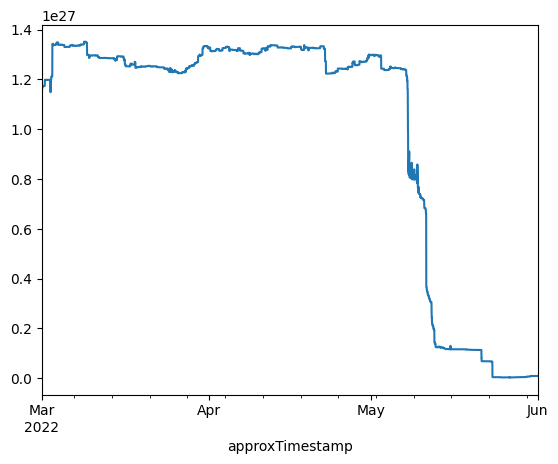

In [32]:
pool_df['totalSupply'].plot()

In [16]:
datafetcher = DataFetcher(token_metadata=token_metadata)
virtual_price_data = datafetcher.get_virtual_price(start_block, end_block, pool, step_size=1000)

In [17]:
df = pd.DataFrame.from_dict([x for y in virtual_price_data for x in y])
df['virtualPrice'] = df['virtualPrice'].astype(int)
df = df.sort_values(by='block')
df['approxTimestamp'] = df['block'].apply(lambda x: datahandler.get_block_timestamp(x)[0]['timestamp'])
df.index = df['approxTimestamp'].apply(datetime.fromtimestamp)
df.head()

,virtualPrice,pool_id,block,approxTimestamp
approxTimestamp,,,,
2022-03-01 00:00:18,1002538059871076792,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,14297759,1646092818
2022-03-01 03:44:56,1002565962509041514,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,14298759,1646106296
2022-03-01 07:31:55,1002565962509041514,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,14299759,1646119915
2022-03-01 11:06:59,1002565962509041514,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,14300759,1646132819
2022-03-01 14:46:52,1002565962509041514,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,14301759,1646146012


In [33]:
def calc_virtual_price(row):
    crv_balance, ust_balance = row['inputTokenBalances']
    return (crv_balance + ust_balance * 1e12)/(row['totalSupply'])
def calc_sum_reserves(row):
    crv_balance, ust_balance = row['inputTokenBalances']
    return (crv_balance + ust_balance * 1e12)

pool_df['virtualPrice'] = pool_df.apply(calc_virtual_price, axis=1)
pool_df['sumReserves'] = pool_df.apply(calc_sum_reserves, axis=1)
pool_df

,inputTokenBalances,totalSupply,virtualPrice,sumReserves
approxTimestamp,,,,
2022-03-01 00:00:00,"[698133431736731494665545838, 455978010849159]",1.166200e+27,0.989634,1.154111e+27
2022-03-01 00:01:00,"[698133431736731494665545838, 455978010849159]",1.166200e+27,0.989634,1.154111e+27
2022-03-01 00:02:00,"[698133431736731494665545838, 455978010849159]",1.166200e+27,0.989634,1.154111e+27
2022-03-01 00:03:00,"[698133431736731494665545838, 455978010849159]",1.166200e+27,0.989634,1.154111e+27
2022-03-01 00:04:00,"[698133431736731494665545838, 455978010849159]",1.166200e+27,0.989634,1.154111e+27
...,...,...,...,...
2022-05-31 23:56:00,"[27670903804032699626838, 10121330902417]",8.643116e+24,1.174230,1.014900e+25
2022-05-31 23:57:00,"[27670903804032699626838, 10121330902417]",8.643116e+24,1.174230,1.014900e+25
2022-05-31 23:58:00,"[27670903804032699626838, 10121330902417]",8.643116e+24,1.174230,1.014900e+25


<Axes: xlabel='approxTimestamp'>

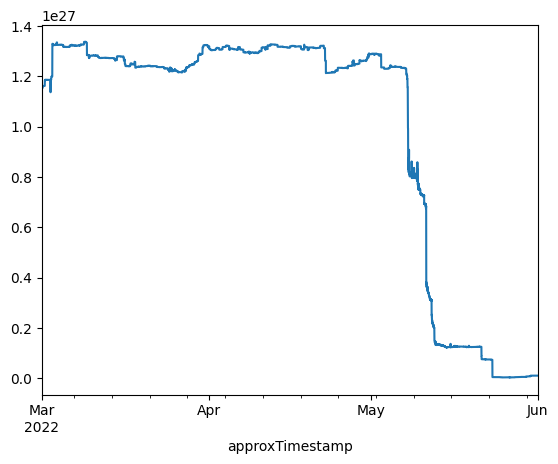

In [35]:
pool_df['sumReserves'].plot()

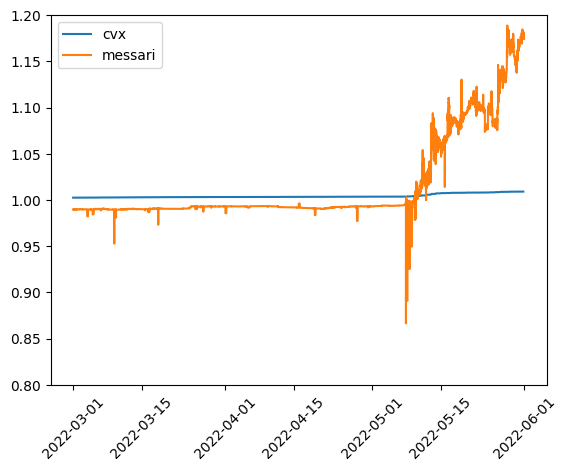

In [36]:
f, ax = plt.subplots()
ax.plot(df.index, df['virtualPrice']/1e18, label='cvx')
ax.plot(pool_df.index, pool_df['virtualPrice'], label='messari')
ax.set_ylim(0.8, 1.2)
ax.legend()
ax.tick_params(axis='x', rotation=45)

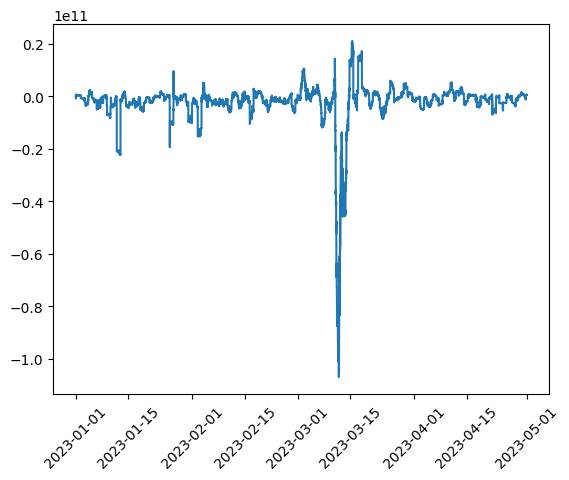

In [66]:
f, ax = plt.subplots()

roller = pool_metrics['USDC.netLPFlow'].rolling('1d').mean()
ax.plot(roller.index, roller)

ax.tick_params(axis='x', rotation=45)

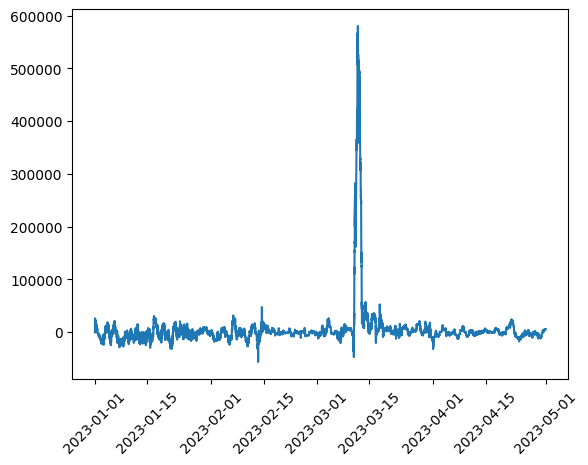

In [67]:
f, ax = plt.subplots()

roller = pool_metrics['USDC.netSwapFlow'].rolling('1d').mean()
ax.plot(roller.index, roller)

ax.tick_params(axis='x', rotation=45)

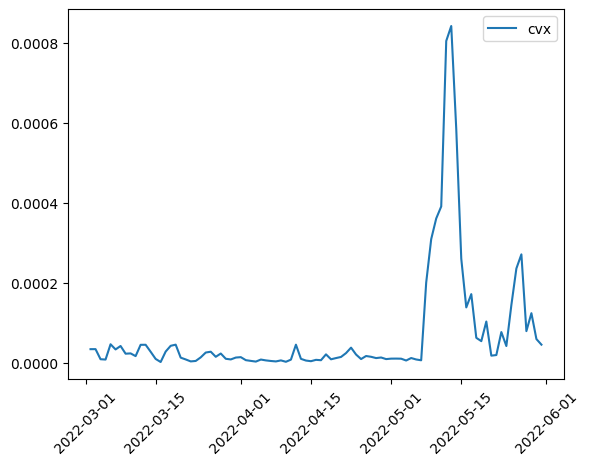

In [13]:
f, ax = plt.subplots()
cvx_returns = (df['virtualPrice']/1e18).resample('1d').last().pct_change()
messari_returns = pool_data['virtualPrice'].resample('1d').last().pct_change()
ax.plot(cvx_returns.index, cvx_returns, label='cvx')
# ax.plot(messari_returns.index, messari_returns, label='messari')
ax.legend()
ax.tick_params(axis='x', rotation=45)

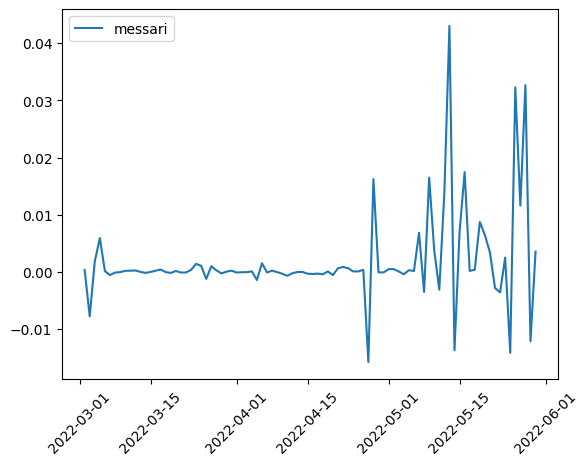

In [14]:
f, ax = plt.subplots()
cvx_returns = (df['virtualPrice']/1e18).resample('1d').last().pct_change()
messari_returns = pool_data['virtualPrice'].resample('1d').last().pct_change()
# ax.plot(cvx_returns.index, cvx_returns, label='cvx')
ax.plot(messari_returns.index, messari_returns, label='messari')
ax.legend()
ax.tick_params(axis='x', rotation=45)